In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import glob
import wget
import tqdm

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as u

import shapely.geometry

from astropy.io import fits
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch, LogStretch, ManualInterval
from astropy.stats import sigma_clip
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel,Tophat2DKernel, convolve

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

In [75]:
manifest = pd.read_csv('C:/Users/oryan/Documents/esac-project/manifests/gz-hubble-local-manifest.csv',index_col=0)

In [76]:
test_id = 'AHZ10004js'

In [77]:
row = manifest.query('zooniverse_id == @test_id')

In [78]:
ra = row.RA.iloc[0]
dec = row.Dec.iloc[0]

In [79]:
coord = SkyCoord(ra = ra, dec = dec, unit = 'deg')
coord_frame = SkyCoord(ra = ra, dec = dec, unit = 'deg', frame='fk5')

In [80]:
obs_table = Observations.query_criteria(
    coordinates = coord,
    radius = 20 * u.arcsec,
    dataproduct_type='image',
    obs_collection = 'HST',
    calib_level = 3,
    filters = ['F814W']
)

In [51]:
wanted_obs = Table.from_pandas(obs_table.to_pandas().sort_values('t_obs_release',ascending=False))

In [52]:
parent_obs = pd.DataFrame(obs_table.to_pandas().obsid.value_counts()).reset_index().rename(columns={'index':'parent_obsid'}).drop(columns='obsid')

In [53]:
data_products = Observations.get_product_list(wanted_obs)

In [72]:
download_products = Table.from_pandas(
    data_products
    .to_pandas()
    .query('dataproduct_type == "image"')
    .query('obs_collection == "HST"')
    .query('type == "D"')
    .query('calib_level == 3')
    .query('productType == "SCIENCE"')
    .query('productSubGroupDescription == "DRC"')
    .merge(parent_obs,on='parent_obsid',how='right')
    .dropna(0,thresh=5)
)

In [73]:
download_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str33,str64,str1,str59,str7,str28,str3,bytes1,str6,str16,str5,str42,int64,str8,str6,int64
26373330,HST,image,hst_10134_15_acs_wfc_f814w_j90r15,HAP fits science image,D,mast:HST/product/hst_10134_15_acs_wfc_f814w_j90r15_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,HAP,DrizzlePac 3.4.1,10134,hst_10134_15_acs_wfc_f814w_j90r15_drc.fits,443036160,26373330,PUBLIC,3
26373334,HST,image,hst_10134_15_acs_wfc_total_j90r15,HAP fits science image,D,mast:HST/product/hst_10134_15_acs_wfc_total_j90r15_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,10134,hst_10134_15_acs_wfc_total_j90r15_drc.fits,443067840,26373330,PUBLIC,3
24822967,HST,image,j90r15030,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,D,mast:HST/product/j90r15030_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,CALACS,DrizzlePac 3.3.1,10134,j90r15030_drc.fits,224256960,26373330,PUBLIC,3
26419080,HST,image,hst_12063_54_acs_wfc_f814w_jbeo54,HAP fits science image,D,mast:HST/product/hst_12063_54_acs_wfc_f814w_jbeo54_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,HAP,DrizzlePac 3.4.1,12063,hst_12063_54_acs_wfc_f814w_jbeo54_drc.fits,271774080,24832396,PUBLIC,3
26419097,HST,image,hst_12063_54_acs_wfc_total_jbeo54,HAP fits science image,D,mast:HST/product/hst_12063_54_acs_wfc_total_jbeo54_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,12063,hst_12063_54_acs_wfc_total_jbeo54_drc.fits,271774080,24832396,PUBLIC,3
24832396,HST,image,jbeo54010,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,D,mast:HST/product/jbeo54010_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,CALACS,DrizzlePac 3.3.1,12063,jbeo54010_drc.fits,216403200,24832396,PUBLIC,3
26437679,HST,image,hst_12177_49_acs_wfc_f814w_jbhj49,HAP fits science image,D,mast:HST/product/hst_12177_49_acs_wfc_f814w_jbhj49_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,HAP,DrizzlePac 3.4.1,12177,hst_12177_49_acs_wfc_f814w_jbhj49_drc.fits,218249280,26437679,PUBLIC,3
26437695,HST,image,hst_12177_49_acs_wfc_total_jbhj49,HAP fits science image,D,mast:HST/product/hst_12177_49_acs_wfc_total_jbhj49_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,12177,hst_12177_49_acs_wfc_total_jbhj49_drc.fits,218249280,26437679,PUBLIC,3
24834246,HST,image,jbhj49010,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,D,mast:HST/product/jbhj49010_drc.fits,SCIENCE,--,DRC,--,CALACS,DrizzlePac 3.3.1,12177,jbhj49010_drc.fits,217474560,26437679,PUBLIC,3


In [56]:
manifest = Observations.download_products(download_products[:3],download_dir = f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{test_id}')

In [60]:
fits_paths = list(manifest['Local Path'])

In [61]:
fits_paths

['C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload\\HST\\hst_10134_15_acs_wfc_f814w_j90r15\\hst_10134_15_acs_wfc_f814w_j90r15_drc.fits',
 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload\\HST\\hst_10134_15_acs_wfc_total_j90r15\\hst_10134_15_acs_wfc_total_j90r15_drc.fits',
 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload\\HST\\j90r15030\\j90r15030_drc.fits']

In [62]:
headers = []
data = []
hdul = []

for i in fits_paths:
    with fits.open(i,memmap=False) as hdul:
        headers.append(hdul[1].header)
        data.append(hdul[1].data)
        hdul.close()

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


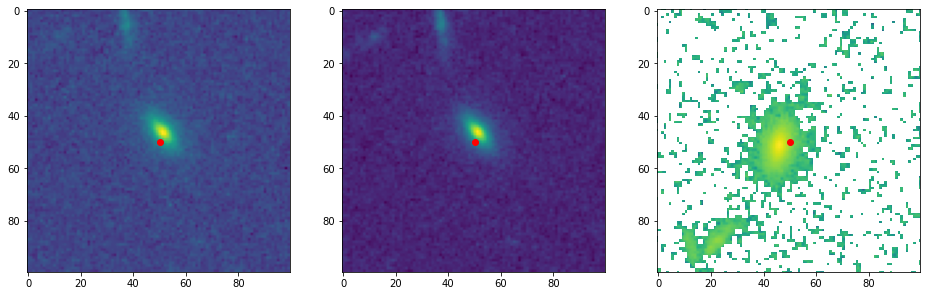

In [63]:
# HST DRC
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(16,16))
for i in range(3):
    w = wcs.WCS(headers[i])
    cutout = Cutout2D(data[i],coord,(100,100),wcs=w,mode='partial').data 
    axes[i].imshow(np.log10(cutout.data))
    axes[i].scatter(cutout.data.shape[0]/2,cutout.data.shape[1]/2,color='red')

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


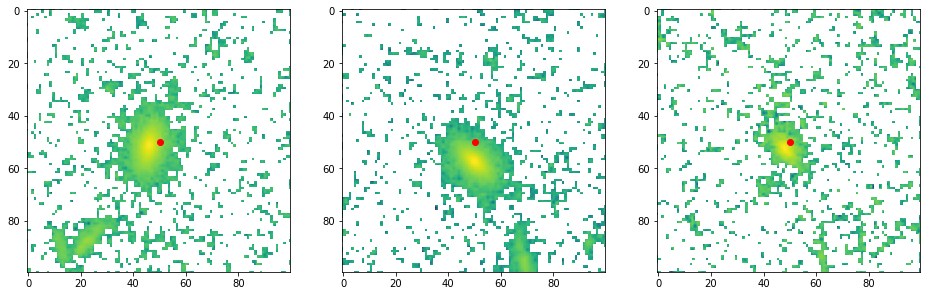

In [43]:
# HST DRZ
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(16,16))
for i in range(3):
    w = wcs.WCS(headers[i])
    cutout = Cutout2D(data[i],coord,(100,100),wcs=w,mode='partial').data 
    axes[i].imshow(np.log10(cutout.data))
    axes[i].scatter(cutout.data.shape[0]/2,cutout.data.shape[1]/2,color='red')

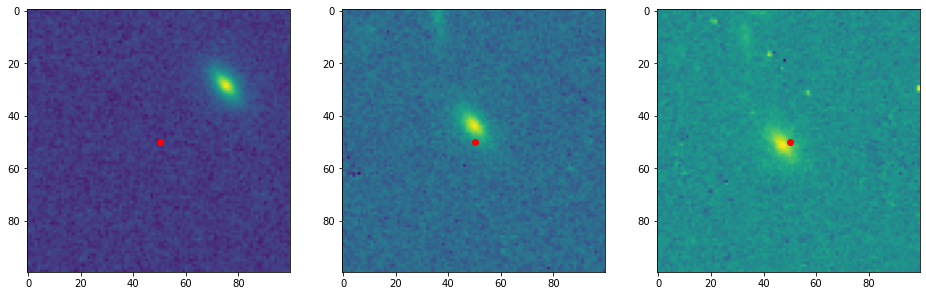

In [66]:
# HLA DRZ
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(16,16))
for i in range(3):
    w = wcs.WCS(headers[i])
    cutout = Cutout2D(data[i],coord,(100,100),wcs=w,mode='partial').data 
    axes[i].imshow(np.log10(cutout.data))
    axes[i].scatter(cutout.data.shape[0]/2,cutout.data.shape[1]/2,color='red')